### Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [1]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
import seaborn as sns
from scipy.stats import pearsonr, normaltest
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import metrics
%matplotlib inline
sns.set_style('whitegrid')

#### Step 2: Examine your data 

In [2]:
df_raw = pd.read_csv("../assets/airport_cancellations.csv")
df = df_raw.dropna() 
print df.head()

  Airport    Year  Departure Cancellations  Arrival Cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   
2     ABQ  2006.0                    392.0                  329.0   
3     ABQ  2007.0                    366.0                  304.0   
4     ABQ  2008.0                    333.0                  300.0   

   Departure Diversions  Arrival Diversions  
0                  71.0                46.0  
1                  61.0                33.0  
2                  71.0               124.0  
3                 107.0                45.0  
4                  79.0                42.0  


In [3]:
df2_raw = pd.read_csv("../assets/Airport_operations.csv")
df2 = df2_raw.dropna() 
print df2.head()

  airport  year  departures for metric computation  \
0     ABQ  2004                              53971   
1     ABQ  2005                              51829   
2     ABQ  2006                              49682   
3     ABQ  2007                              53255   
4     ABQ  2008                              49589   

   arrivals for metric computation  percent on-time gate departures  \
0                            53818                           0.8030   
1                            51877                           0.8140   
2                            51199                           0.7983   
3                            53611                           0.8005   
4                            49512                           0.8103   

   percent on-time airport departures  percent on-time gate arrivals  \
0                              0.7809                         0.7921   
1                              0.7922                         0.8001   
2                              0

### Intro: Write a problem statement / aim for this project

I have been hired by the FAA as a consultant to analyze the operations of major airports around the country. The FAA wants to cut down on delays nationwide, and the most important part of this task is understanding the characteristics and groupings of airports based on a dataset of departure and operational delays.

The datasets provided include a dataset detailing the arrival and departure delays/diversions by airport, a dataset that provides metrics related to arrivals and departures for each airport, and a dataset that details names and characteristics for each airport code.

Using the provided datasets, I intend to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.  I will conduct PCA analysis to reveal the core components leading to delays in the airports.

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [4]:
import psycopg2  
from sqlalchemy import create_engine

We start by creating access to a local database utilizing postgres

In [5]:
from sqlalchemy import create_engine
import getpass

p = getpass.getpass() #makes it so we don't have the password in the code, not good for script building

········


In [6]:
engine = create_engine('postgresql://Lappy9000:%s@localhost:5432/airport_db' % p)

Load our csv files into tables

In [7]:
df.to_sql('cancellations', con=engine, if_exists='replace')

In [8]:
df2.to_sql('operations', con=engine, if_exists='replace')

In [9]:
print df.columns
print df2.columns

Index([u'Airport', u'Year', u'Departure Cancellations',
       u'Arrival Cancellations', u'Departure Diversions',
       u'Arrival Diversions'],
      dtype='object')
Index([u'airport', u'year', u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay'],
      dtype='object')


Join airport_cancellations.csv and operations.csv into one table

In [10]:
joined_tables = pd.read_sql_query("SELECT * FROM operations INNER JOIN cancellations ON airport = Airport;", con=engine)
#con.commit()
joined_tables.head() 

,index,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,...,average taxi in delay,average block delay,average gate arrival delay,index,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,...,0.83,2.55,10.87,0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,...,0.89,2.34,10.24,0,ABQ,2004.0,242.0,235.0,71.0,46.0
2,2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,...,0.84,2.66,11.82,0,ABQ,2004.0,242.0,235.0,71.0,46.0
3,3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,...,1.29,3.06,12.71,0,ABQ,2004.0,242.0,235.0,71.0,46.0
4,4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,...,1.03,2.79,11.48,0,ABQ,2004.0,242.0,235.0,71.0,46.0


In [11]:
joined_tables.count()

index                                 677005
airport                               677005
year                                  677005
departures for metric computation     677005
arrivals for metric computation       677005
percent on-time gate departures       677005
percent on-time airport departures    677005
percent on-time gate arrivals         677005
average_gate_departure_delay          677005
average_taxi_out_time                 677005
average taxi out delay                677005
average airport departure delay       677005
average airborne delay                677005
average taxi in delay                 677005
average block delay                   677005
average gate arrival delay            677005
index                                 677005
Airport                               677005
Year                                  677005
Departure Cancellations               677005
Arrival Cancellations                 677005
Departure Diversions                  677005
Arrival Di

Query the database for our intial data

In [86]:
df3 = joined_tables.dropna()
df3.to_csv('df3.csv')

In [88]:
#saving df3 to a csv file for easier access as I work on the project
df3 = pd.read_csv('../starter-code/df3.csv')
df3.head()

,Unnamed: 0,index,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,...,average taxi in delay,average block delay,average gate arrival delay,index.1,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,0,0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,...,0.83,2.55,10.87,0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,1,1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,...,0.89,2.34,10.24,0,ABQ,2004.0,242.0,235.0,71.0,46.0
2,2,2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,...,0.84,2.66,11.82,0,ABQ,2004.0,242.0,235.0,71.0,46.0
3,3,3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,...,1.29,3.06,12.71,0,ABQ,2004.0,242.0,235.0,71.0,46.0
4,4,4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,...,1.03,2.79,11.48,0,ABQ,2004.0,242.0,235.0,71.0,46.0


In [89]:
df3.count()

Unnamed: 0                            677005
index                                 677005
airport                               677005
year                                  677005
departures for metric computation     677005
arrivals for metric computation       677005
percent on-time gate departures       677005
percent on-time airport departures    677005
percent on-time gate arrivals         677005
average_gate_departure_delay          677005
average_taxi_out_time                 677005
average taxi out delay                677005
average airport departure delay       677005
average airborne delay                677005
average taxi in delay                 677005
average block delay                   677005
average gate arrival delay            677005
index.1                               677005
Airport                               677005
Year                                  677005
Departure Cancellations               677005
Arrival Cancellations                 677005
Departure 

#### 1.2 What are the risks and assumptions of our data? 

Since this dataset was provided to us we are assuming it's accuracy.  Human error could cause discrepency in the data and influence any correaltion we arrive at in our analysis.  

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [90]:
df3.describe()

,Unnamed: 0,index,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,...,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,index.1,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
count,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,...,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000,677005.000000
mean,338502.000000,420.000000,2009.028537,108257.063020,107815.561237,0.764119,0.714283,0.754281,13.561403,13.703389,...,2.921237,1.348894,3.330773,14.013222,402.000000,2008.986335,1292.038509,1333.124224,173.315528,169.413665
std,195434.653833,242.775796,3.154622,98220.027197,97858.748987,0.093305,0.101211,0.082253,4.743744,3.789929,...,1.200739,0.881728,1.026262,4.479552,232.383476,3.156156,1834.822595,1973.999097,172.238586,228.379800
min,0.000000,0.000000,2004.000000,261.000000,259.000000,0.246700,0.245700,0.324100,5.350000,7.040000,...,0.950000,0.000000,1.230000,6.330000,0.000000,2004.000000,0.000000,0.000000,0.000000,0.000000
25%,169251.000000,210.000000,2006.000000,37653.000000,37502.000000,0.745700,0.684800,0.737500,10.910000,11.260000,...,2.050000,0.800000,2.630000,11.300000,201.000000,2006.000000,349.000000,314.000000,62.000000,41.000000
50%,338502.000000,420.000000,2009.000000,72043.000000,71254.000000,0.782500,0.737200,0.768300,12.640000,12.810000,...,2.650000,1.080000,3.160000,13.080000,402.000000,2009.000000,663.000000,642.000000,110.000000,84.000000
75%,507753.000000,630.000000,2012.000000,162913.000000,160775.000000,0.809800,0.772200,0.796500,14.950000,15.650000,...,3.620000,1.740000,3.860000,15.250000,603.000000,2012.000000,1472.000000,1523.000000,236.000000,190.000000
max,677004.000000,840.000000,2014.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,40.800000,35.760000,...,7.820000,6.180000,7.520000,34.880000,804.000000,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000


I chose to pay special attention to the average taxi out time, average gate departure delay, and average airborn delay as these columns seem to be the most important in regards to answering our questions centering around airline delays.

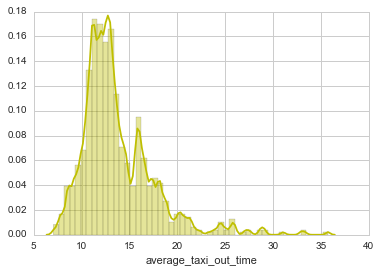

In [91]:
sns.distplot(df3['average_taxi_out_time'], hist=True, color="y")

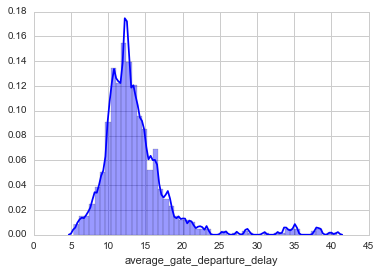

In [92]:
sns.distplot(df3['average_gate_departure_delay'], hist=True, color="b")

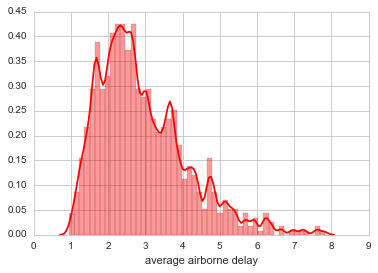

In [93]:
sns.distplot(df3['average airborne delay'], hist=True, color="r")

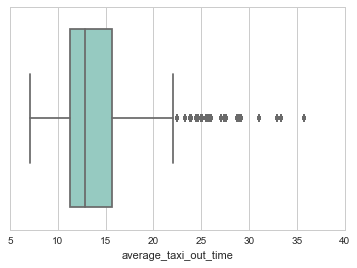

In [94]:
sns.boxplot(df3['average_taxi_out_time'], palette="Set3")

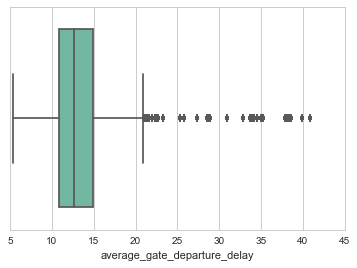

In [95]:
sns.boxplot(df3['average_gate_departure_delay'], palette="Set2")

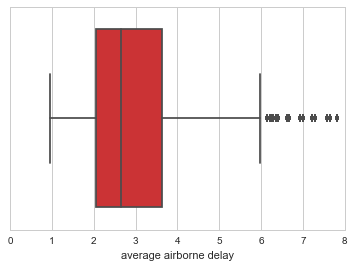

In [96]:
sns.boxplot(df3['average airborne delay'], palette="Set1")

#### Are there any unique values? 

The aiport column showcases a wide variety of unique values:

In [97]:
df3.airport.unique()

array(['ABQ', 'ANC', 'ATL', 'AUS', 'BDL', 'BHM', 'BNA', 'BOS', 'BUF',
       'BUR', 'BWI', 'CLE', 'CLT', 'CVG', 'DAL', 'DAY', 'DCA', 'DEN',
       'DFW', 'DTW', 'EWR', 'FLL', 'GYY', 'HNL', 'HOU', 'HPN', 'IAD',
       'IAH', 'IND', 'ISP', 'JAX', 'JFK', 'LAS', 'LAX', 'LGA', 'LGB',
       'MCI', 'MCO', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE', 'MSP', 'MSY',
       'OAK', 'OGG', 'OMA', 'ONT', 'ORD', 'OXR', 'PBI', 'PDX', 'PHL',
       'PHX', 'PIT', 'PSP', 'PVD', 'RDU', 'RFD', 'RSW', 'SAN', 'SAT',
       'SDF', 'SEA', 'SFO', 'SJC', 'SJU', 'SLC', 'SMF', 'SNA', 'STL',
       'SWF', 'TEB', 'TPA', 'TUS', 'VNY'], dtype=object)

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [98]:
dummyair = preprocessing.LabelEncoder()
df3.airport = dummyair.fit_transform(df3.airport)

In [99]:
df3.head()

,Unnamed: 0,index,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,...,average taxi in delay,average block delay,average gate arrival delay,index.1,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,0,0,0,2004,53971,53818,0.8030,0.7809,0.7921,10.38,...,0.83,2.55,10.87,0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,1,1,0,2005,51829,51877,0.8140,0.7922,0.8001,9.60,...,0.89,2.34,10.24,0,ABQ,2004.0,242.0,235.0,71.0,46.0
2,2,2,0,2006,49682,51199,0.7983,0.7756,0.7746,10.84,...,0.84,2.66,11.82,0,ABQ,2004.0,242.0,235.0,71.0,46.0
3,3,3,0,2007,53255,53611,0.8005,0.7704,0.7647,11.29,...,1.29,3.06,12.71,0,ABQ,2004.0,242.0,235.0,71.0,46.0
4,4,4,0,2008,49589,49512,0.8103,0.7844,0.7875,10.79,...,1.03,2.79,11.48,0,ABQ,2004.0,242.0,235.0,71.0,46.0


#### 3.2 Format and Clean the Data

Creating variables off of the below columns will help us simplify our code in our PCA analysis.

In [100]:
taxi = df3['average_taxi_out_time']
gate_delay = df3['average_gate_departure_delay']
year = df3['year']
taxi_delay = df3['average taxi out delay']
airborne_delay = df3['average airborne delay']

Need to remove the below columns to allow our dataset to meet a normal distribution:

In [101]:
del df3['departures for metric computation']
del df3['arrivals for metric computation']
del df3['Airport']

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

Using SciPy to our advantage we can utilize the function "normaltest" to determine if our datset has a normal distribution.  The scipy documention states, "This function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality."

In [102]:
normaltest(df3)

NormaltestResult(statistic=array([ 601312.66835318,  601332.70315474,  572376.44707492,
        682120.48632101,  452130.8371191 ,  268681.11963836,
        388666.28044673,  381727.90994623,  241371.15242566,
        343228.46193773,  223774.30842342,   99705.50799271,
        179981.514105  ,   89504.1932594 ,  282416.88715862,
        601334.44376626,  711642.1691817 ,  546823.0293196 ,
        543249.8270913 ,  273819.13674719,  437522.68805677]), pvalue=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [103]:
df3_normalized = preprocessing.normalize(df3, norm='l2')

#### 4.2 Find correlations in the data

As we move in to finding correlations and PCA analysis, it will be helpful to look at a specific portion of the dataset.  The below code truncates the columns we will be looking at to fit our model, using the variables we created earlier.

In [104]:
taxi1 = taxi[0:1000]
gate_delay1 = gate_delay[0:1000]
year1 = year[0:1000]
taxi_delay1 = taxi_delay[0:1000]
airborne_delay1 = airborne_delay[0:1000]

"personr" calculates a Pearson correlation coefficient and the p-value for testing
non-correlation.  

The documentation for The Pearson correlation coefficient states that it, "measures the linear relationship between two datasets. Strictly speaking, Pearson's correlation requires that each dataset be normally distributed, and not necessarily zero-mean. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases."


The p-value measures the strength of the relationship between x and y. In other words, it shows us how likely it is that the null hypothesis is true and in the case of a correlation, how likely it is that two arrays are or are not related to each other.  As the documentation states, p-values are not entirely reliable but are reasonable for datasets larger than 500 or so.

In [105]:
pearsonr(taxi1, airborne_delay1)

(0.52207601409465054, 5.2380583934433219e-71)

In [106]:
pearsonr(year1, airborne_delay1)

(-0.35284387346879525, 1.0909315519623537e-30)

In [107]:
pearsonr(gate_delay1, airborne_delay1)

(0.3835672471338829, 2.1283622921756145e-36)

The personr tests have shown us that we are dealing with linear relationships in the datasets we have chosen to look at. In the case of year to airborne delay, y will decrease as x increases - whereas when comparing airborne delay to taxi delay and and gate delay, y will increase as x increases.

An interesting observation here is that the data seems to be indicating that the older the airport data, the more frequent airborne delays.  This would imply that over time, as airports modernized, they saw less airborne delays.  One suggestion that could come out of this, if proven true, would be to invest in modernizing the older airports.

#### 4.3 What is the value of understanding correlations before PCA? 

Highly correlated variables will help us better understand patterns in our data as they are a common factor in PCA analysis.

#### 4.4 How can you improve your overall analysis? 

We may be able to improve our analysis by reducing the amount of elements in our dataset.  We could also possibly find better correlations in other datasets.

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

In [77]:
# Create a clean data frame 
df4 = df3[['airport','year','average_taxi_out_time','average_gate_departure_delay', 'average taxi out delay', 'average airborne delay']]
print df4.head()

   airport  year  average_taxi_out_time  average_gate_departure_delay  \
0        0  2004                   9.89                         10.38   
1        0  2005                   9.79                          9.60   
2        0  2006                   9.89                         10.84   
3        0  2007                  10.34                         11.29   
4        0  2008                  10.41                         10.79   

   average taxi out delay  average airborne delay  
0                    2.43                    2.46  
1                    2.29                    2.26  
2                    2.16                    2.12  
3                    2.40                    2.19  
4                    2.41                    1.82  


Before diving deep in to PCA analysis, we can find some interesting correlations out of the raw data.  To do that I will create a dataset built on the most interesting columns in relation to delays.

In [78]:
df4_columns = ['average_taxi_out_time','average_gate_departure_delay', 'average taxi out delay', 'average airborne delay']
df4_compare = df4[df4_columns]

We can then take those columns and standardize them with some simple arithmetic:

In [79]:
df4_compare = (df4_compare - df4_compare.mean()) / df4_compare.std()

This allows us to see some basic correlations across the columns associated with delays - date is not included here.

We see a direct correlation between average taxi out time and average departure delay, which is not suprising. 

However, average taxi out delay and average airborne delay do not seem to be correlated and that has some interesting implication.

We will move on to a more robust PCA analysis from here to see if we can prove out these correlations in further detail.

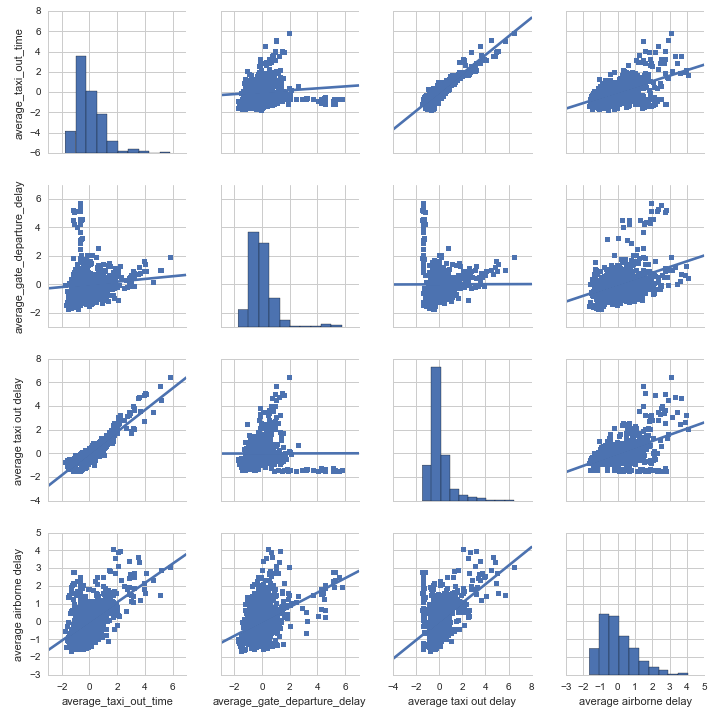

In [81]:
sns.pairplot(df4_compare, kind='reg')

I will now define my x and y variables to conduct a more in depth PCA analysis:

In [26]:
x = df4.ix[:,1:6].values
y = df4.ix[:,0].values

I then want to standardize my x variable (I chose to do this using StandardScalar):

In [27]:
xStand = preprocessing.StandardScaler().fit_transform(x)

Next we create the coveriance matrix (Covariance indicates the level to which two variables vary together):

In [28]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

Then we can check the Eigenvalues and Eigenvectors:

In [29]:
print(eigenValues)

[ 2.44388812  0.07281262  0.32263724  1.02017005  1.14049936]


In [30]:
print(eigenVectors)

[[ 0.19306352 -0.0906295  -0.32050182  0.89458841 -0.22694258]
 [-0.57588793  0.70638184  0.20813431  0.19517447 -0.29658865]
 [-0.18115436 -0.05769204  0.44411399  0.39109011  0.78336838]
 [-0.57410332 -0.69922001  0.24166833  0.05160777 -0.34702999]
 [-0.51833198 -0.02395826 -0.7735101  -0.07748336  0.35557898]]


An eigenvalue tells us how much variance exists in the data in a certain direction, which is represented by theeigenvector. When conducting PCA analysis, think of our data as an ellipse, with the datapoints marking the outside rim of this elipse. When decomposed, the selected datapoints forming the outside of this ring are our eigenvalues.

Now, let's imagine we drew a straight axis through the middle of this elipse; the distance between these points the axis would represent our eigenvectors From this, the eigenvectors that has the highest associated eigenvalues are our principal components.

As you can see, there is an intuitive relationship between the covariance matrix and the eigenvectors/eigenvalues. Where the covariance matrix represents covariance across dimensions, its decomposition directly results in the eigenvector, which measures variance - we are simply reducing the dimensions so that we are left with fewer values.

This also allows us to find the Eigen Pairs:

In [27]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

2.44388811951
1.14049935853
1.02017005327
0.322637238878
0.0728126152871


Now we can conduct our PCA analysis:

In [44]:
PCA_A = PCA(n_components=5)
Y = PCA_A.fit_transform(xStand)

In [45]:
print Y

[[ 0.85408798  0.15646283 -1.87843258 -0.1905465   0.19955778]
 [ 1.08023724 -0.07535569 -1.65442507 -0.1251146   0.19248764]
 [ 1.17055318  0.0270676  -1.25723808 -0.2221403   0.17683032]
 ..., 
 [ 0.52361749  3.13195367  1.83046886 -0.19949381 -0.24225838]
 [ 1.08859431  2.59800276  2.23478444 -1.06462088 -0.21664182]
 [ 0.77404429  2.77980503  2.50144188 -0.50341615 -0.21039137]]


Creating a dataframe from the PCA analysis will allow us to visualize our results:

In [46]:
Ydf = pd.DataFrame(Y, columns=["PC1", "PC2", "PCA3", "PCA4", "PCA5"])

In [47]:
components = PCA_A.components_

We can use the below code to show the results of our PC vectors.  This allows us to observe some very relevant correlations in regards to delays in respect to our dataset.

The index shows you what each vector represents - starting with year and going in order after that.  So in the case of PC1 weighting vector: Year = 0.19306352, Average Taxi Out Time = -0.57588793, Average Gate Departure Delay = -0.18115436,  Average Taxi Out Delay = -0.57410332, and Average Airborne Delay = -0.51833198".  

The below weighting vectors further prove that age has a direct correlation to delays.  Take note that whenever the Year vector is positive, the vectors associated with delays are in the negative.  

We also see a correlation between Average Taxi Out Time and Average Taxi Out Delay - which is predictable.  

Perhaps surprisingly, we also can take note that Average Airborne delay and Average Taxi Out Delay do not seem correlated.  This would imply that delays can occur whether an aircraft is on time or late to get off the ground.  

In [53]:
print df4.columns, '\n'
print '-------------------------------------\n'

for i, pc in enumerate(['PC1','PC2','PC3', 'PC4', 'PC5']):
    print pc, 'weighting vector:', components[i]
    print '-------------------------------------\n'

Index([u'airport', u'year', u'average_taxi_out_time',
       u'average_gate_departure_delay', u'average taxi out delay',
       u'average airborne delay'],
      dtype='object') 

-------------------------------------

PC1 weighting vector: [ 0.19306352 -0.57588793 -0.18115436 -0.57410332 -0.51833198]
-------------------------------------

PC2 weighting vector: [-0.22694258 -0.29658865  0.78336838 -0.34702999  0.35557898]
-------------------------------------

PC3 weighting vector: [ 0.89458841  0.19517447  0.39109011  0.05160777 -0.07748336]
-------------------------------------

PC4 weighting vector: [ 0.32050182 -0.20813431 -0.44411399 -0.24166833  0.7735101 ]
-------------------------------------

PC5 weighting vector: [ 0.0906295  -0.70638184  0.05769204  0.69922001  0.02395826]
-------------------------------------



We can also use a new dataframe - utilizing the airport and year columns - and join the PCA results with the new dataframe to form a new set and speak directly to our problem statement:

In [49]:
df5 = df4[['airport', 'year']]

In [50]:
airport_pca = df5.join(Ydf, on=None, how='left')

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied

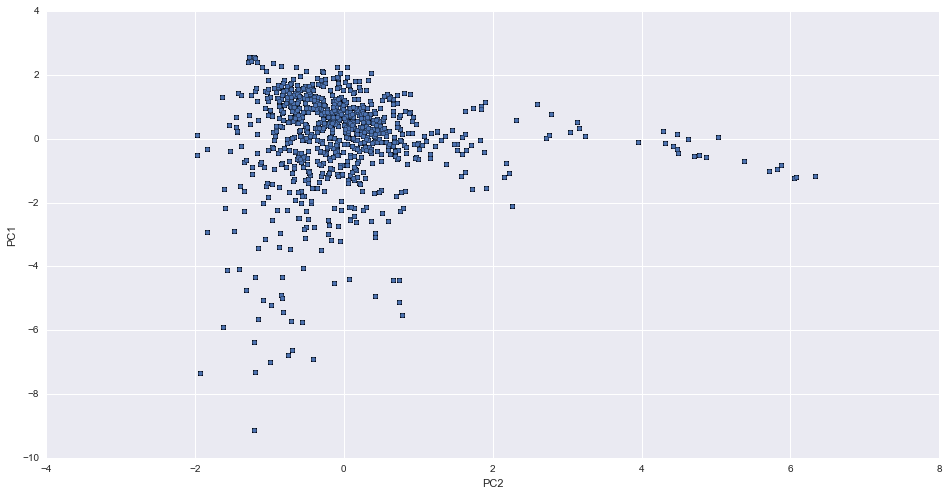

In [51]:
graph = airport_pca.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))
graph

#### 5.2 Write an analysis plan of your findings 

PCA turned out to be a great resource in helping us better understand the provided dataset in relation to aiport/airline delays.  

By far, the most helpful observation came from the age correlation we discovered in our PCA analysis.  In every model we tested, we saw a distinct increase in delays across the board, the older the report was.  This indicates that as airports and airlines modernized, they reduced their delays.  This justifies an argument that if aiports invested resources in modernizing their airlines and airports - they would see a decrease in delays both on the ground and in the air.  This would be my initial recommendation to the FAA.  

From here I would like to build a more robust module in correlation to age, utilizing some other modeling techniques that could solidify the above recommendation.  I would also like to test some other models to find out what other correlations could be found in the data we were provided.  We did not look at the percentage of on time arrivals and departures, and I think there could be some very useful data in there.

### Part 6: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

In [ ]:
psql \
   -f mydb2dump.sql \
   --host dsi.cp1ptjkm04bz.us-west-1.rds.amazonaws.com \
   --port 5432 \
   --username usr_username \
   --password usr_psswrd \
   --dbname testtest 

Worked through terminal and posgres to put the databse on AWS using the template above as my final code.